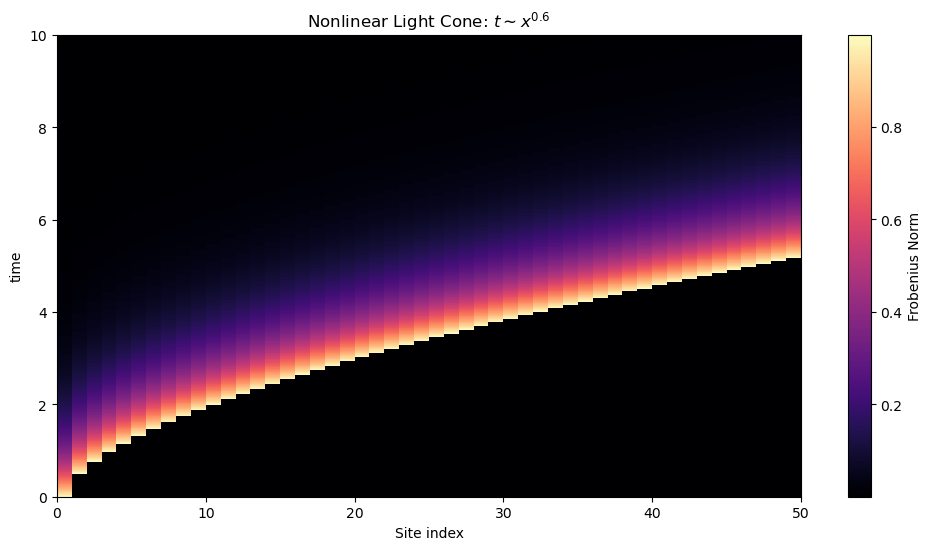

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
nsites = 50
ntimes = 1000
A = 0.5               # Prefactor for arrival time
zeta = 0.6            # Sublinear scaling exponent (zeta < 1)
noise_level = 1e-4

sites = np.arange(nsites)
times = np.linspace(0, 10, ntimes)

# Create meshgrid for time and site
T, X = np.meshgrid(times, sites, indexing='ij')

# Nonlinear arrival time
arrival_times = A * (X**zeta)  # Shape: (ntimes, nsites)

# Frobenius Norm: Near zero before arrival, rises sharply after
F = np.zeros_like(T)

for i in range(nsites):
    t_arr = arrival_times[:, i]
    for j in range(ntimes):
        if times[j] > t_arr[j]:
            # Example: exponential decay after arrival
            F[j, i] = np.exp(-(times[j] - t_arr[j])) + noise_level * np.random.rand()
        else:
            F[j, i] = noise_level * np.random.rand()

# Optional: Apply log and clip very small values
# F_log = np.log(F)
# F_log[F_log < -10] = -10

# === Plot ===
plt.figure(figsize=(12, 6))
im = plt.imshow(F, aspect='auto', origin='lower', extent=[0, nsites, 0, 10],
                cmap='magma', interpolation='none')
plt.colorbar(im, label='Frobenius Norm')
plt.xlabel('Site index')
plt.ylabel('time')
plt.title(f'Nonlinear Light Cone: $t \\sim x^{{{zeta}}}$')
plt.show()


In [9]:
import numpy as np

threshold = 0.02  # Adjust as needed

arrival_times = []
site_indices = np.arange(F.shape[1])

for site in site_indices:
    norm_vs_time = F[:, site]
    
    # Find indices where Frobenius norm crosses threshold
    above_thresh = np.where(norm_vs_time > threshold)[0]
    
    if len(above_thresh) > 0:
        # Take the first crossing index as arrival time
        arrival_idx = above_thresh[0]
        arrival_times.append(times[arrival_idx])
    else:
        # No arrival detected; keep NaN to mark missing arrival
        arrival_times.append(np.nan)

arrival_times = np.array(arrival_times)

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Arrival times (your y-values)
y = np.array([
    0.01001001, 0.5005005 , 0.76076076, 0.97097097, 1.15115115,
    1.32132132, 1.47147147, 1.61161161, 1.74174174, 1.87187187,
    1.99199199, 2.11211211, 2.22222222, 2.33233233, 2.44244244,
    2.54254254, 2.64264264, 2.74274274, 2.83283283, 2.93293293,
    3.02302302, 3.11311311, 3.2032032 , 3.28328328, 3.37337337,
    3.45345345, 3.53353353, 3.61361361, 3.69369369, 3.77377377,
    3.85385385, 3.93393393, 4.004004  , 4.08408408, 4.15415415,
    4.22422422, 4.29429429, 4.36436436, 4.44444444, 4.5045045 ,
    4.57457457, 4.64464464, 4.71471471, 4.78478478, 4.84484484,
    4.91491491, 4.97497497, 5.04504505, 5.10510511, 5.17517518
])

# Site indices (x-values)
x = np.arange(len(y)).reshape(-1, 1)
y = y.reshape(-1, 1)

# Split into train and validation sets
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state=42)

print("x_train shape:", x_train.shape)
print("x_val shape:", x_val.shape)

print("First 5 x_train samples:\n", x_train[:5])
print("First 5 x_val samples:\n", x_val[:5])

x_train shape: (35, 1)
x_val shape: (15, 1)
First 5 x_train samples:
 [[ 6]
 [41]
 [46]
 [47]
 [15]]
First 5 x_val samples:
 [[13]
 [39]
 [30]
 [45]
 [17]]


In [60]:
# Try polynomial fits from degree 1 to 14
degrees = range(1, 15)
val_errors = []

for d in degrees:
    poly = PolynomialFeatures(degree=d)
    x_train_poly = poly.fit_transform(x_train)
    x_val_poly = poly.transform(x_val)

    model = LinearRegression()
    model.fit(x_train_poly, y_train)
    y_val_pred = model.predict(x_val_poly)

    mse = mean_squared_error(y_val, y_val_pred)
    val_errors.append(mse)



Best polynomial degree: 7
Coefficients: [[ 0.00000000e+00  3.99376159e-01 -4.25088210e-02  3.35341122e-03
  -1.51138384e-04  3.80863859e-06 -4.99717495e-08  2.65686404e-10]]
Intercept: [0.07090978]


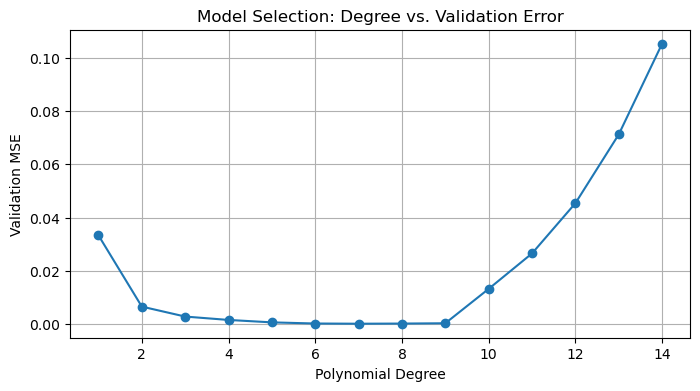

In [71]:
# Find best degree (minimum validation error)
best_degree = degrees[np.argmin(val_errors)]
print(f"Best polynomial degree: {best_degree}")

# Fit final model on all data
poly = PolynomialFeatures(degree=best_degree)
x_poly = poly.fit_transform(x)
model = LinearRegression()
model.fit(x_poly, y)
y_pred = model.predict(x_poly)

print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)


# Plot validation error vs degree
plt.figure(figsize=(8, 4))
plt.plot(degrees, val_errors, marker='o')
plt.xlabel("Polynomial Degree")
plt.ylabel("Validation MSE")
plt.title("Model Selection: Degree vs. Validation Error")
plt.grid(True)
plt.savefig('img/Model Selection.png', dpi=300, bbox_inches='tight')
plt.show()


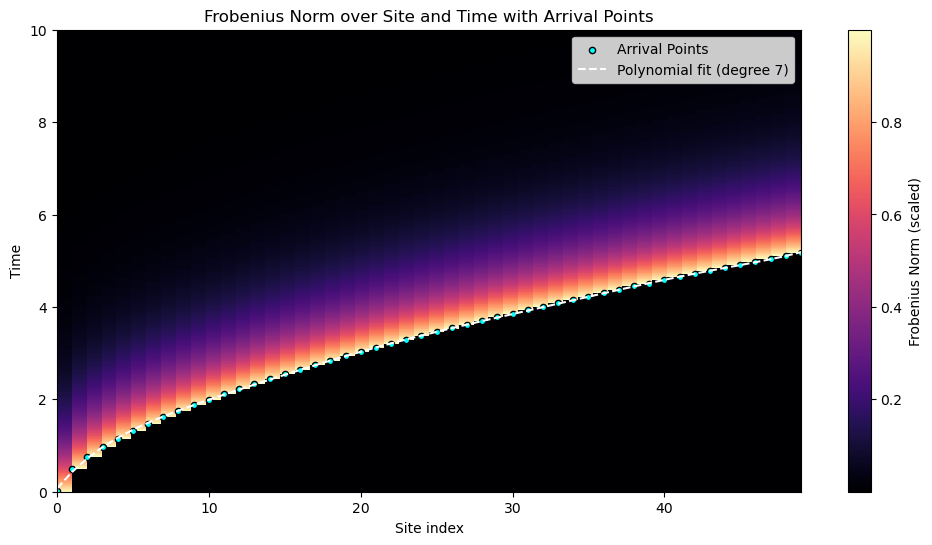

In [70]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
im = plt.imshow(F, aspect='auto', origin='lower',
                extent=[0, F.shape[1]-1, times[0], times[-1]],
                cmap='magma', interpolation='none')
plt.colorbar(im, label='Frobenius Norm (scaled)')
plt.xlabel('Site index')
plt.ylabel('Time')

coeffs = np.round(np.append(model.intercept_, model.coef_[1:]), 2)


# Plot arrival points (exclude NaNs)
valid_arrivals = ~np.isnan(arrival_times)
plt.scatter(site_indices[valid_arrivals], arrival_times[valid_arrivals],
            color='cyan', label='Arrival Points', s=20, edgecolors='k')
plt.plot(x, y_pred, label=f'Polynomial fit (degree {best_degree})', color='white', linestyle='--')

plt.legend()
plt.title('Frobenius Norm over Site and Time with Arrival Points')
plt.savefig('img/NonlinearLC.png', dpi=300, bbox_inches='tight')

plt.show()